In [ ]:
import pandas as pd
import numpy as np

# --- STAGE 1: LOAD THE DATA ---
# This line creates the 'df' DataFrame, fixing the error.
# Make sure your CSV file is in the same folder as your notebook.
print("Loading data...")
df = pd.read_csv(r"C:\Users\anura\Downloads\_stroke-prediction (3)\healthcare-dataset-stroke-data.csv")
print("Data loaded successfully.")

# --- STAGE 2: CLEAN THE DATA ---
# Fill missing BMI values with the median
print("\nCleaning data...")
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True)
print("Missing BMI values handled.")

# --- STAGE 3: TRANSFORM SKEWED COLUMNS ---
# Define the columns that need fixing
cols_to_transform = ['avg_glucose_level', 'bmi']

print("\nApplying log transformation to fix skewness...")
# Apply the log transform using numpy
for col in cols_to_transform:
    df[col] = np.log1p(df[col])
print("Transformation complete.")

# --- Verification ---
print("\n--- FINAL SKEWNESS ---")
print(df[cols_to_transform].skew())

In [ ]:
df.head(5)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice visual style for the plots
sns.set_style('whitegrid')

# Create a count plot for the 'stroke' variable
plt.figure(figsize=(7, 5))
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Stroke Cases')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.xlabel('Stroke Outcome')
plt.ylabel('Number of Patients')
plt.show()

In [ ]:
# Create a histogram to see age distribution by stroke status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', kde=True)
plt.title('Age Distribution by Stroke Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [ ]:
# Create subplots for multiple categorical features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Hypertension
sns.countplot(ax=axes[0], x='hypertension', hue='stroke', data=df)
axes[0].set_title('Hypertension vs. Stroke')
axes[0].set_xticklabels(['No Hypertension', 'Hypertension'])

# Plot for Heart Disease
sns.countplot(ax=axes[1], x='heart_disease', hue='stroke', data=df)
axes[1].set_title('Heart Disease vs. Stroke')
axes[1].set_xticklabels(['No Heart Disease', 'Heart Disease'])

plt.tight_layout()
plt.show()

In [ ]:
# Select only numerical columns for the correlation matrix
numerical_cols = df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numerical_cols.corr()

# Plot the heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [ ]:
# Convert all categorical columns into numerical ones using one-hot encoding
print("Original number of columns:", df.shape[1])

# We add dtype=int to ensure the new columns are 1s and 0s
df_encoded = pd.get_dummies(df, 
                            columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], 
                            drop_first=True, 
                            dtype=int)

print("New number of columns after encoding:", df_encoded.shape[1])

# Display the first few rows to see the new 0/1 columns
df_encoded.head()


In [ ]:
# Separate the features (X) from the target variable (y)
X = df_encoded.drop(['stroke', 'id'], axis=1)
y = df_encoded['stroke']

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new class distribution
print("Original class distribution:\n", y.value_counts())
print("\nNew class distribution after SMOTE:\n", y_resampled.value_counts())

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Create and train the model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate the model
print("--- Logistic Regression Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("--- Random Forest Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))

In [ ]:
# You might need to install XGBoost first: pip install xgboost
import xgboost as xgb

# Create and train the model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("--- XGBoost Results ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(classification_report(y_test, y_pred_xgb))

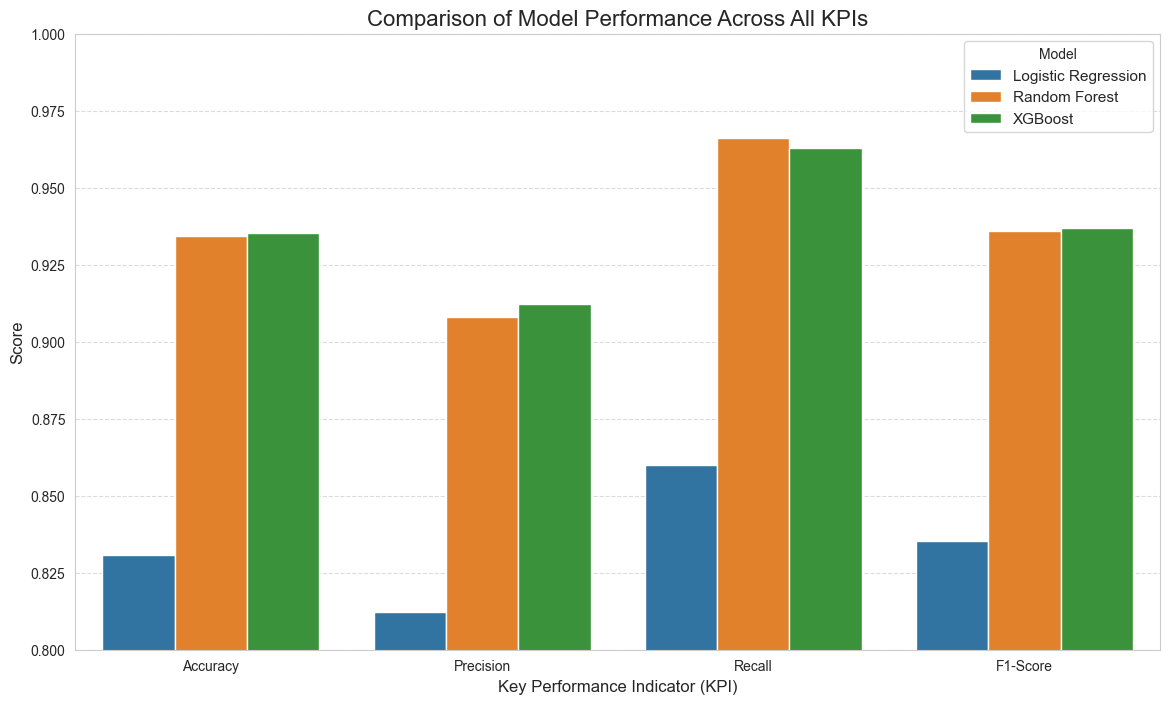

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# --- Make sure you have these variables from the previous training steps ---
# y_test, y_pred_lr, y_pred_rf, y_pred_xgb

# --- Calculate all metrics for each model ---
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "XGBoost": y_pred_xgb
}

# Create a list to store the results
plot_data = []

for model_name, y_pred in models.items():
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate metrics specifically for the positive class (stroke=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    plot_data.extend([
        {'Model': model_name, 'KPI': 'Accuracy', 'Score': accuracy},
        {'Model': model_name, 'KPI': 'Precision', 'Score': precision},
        {'Model': model_name, 'KPI': 'Recall', 'Score': recall},
        {'Model': model_name, 'KPI': 'F1-Score', 'Score': f1}
    ])

# Convert the list of dictionaries to a pandas DataFrame for easy plotting
df_plot = pd.DataFrame(plot_data)


# --- Create the grouped bar chart ---
plt.figure(figsize=(14, 8))
sns.barplot(x='KPI', y='Score', hue='Model', data=df_plot)

plt.title('Comparison of Model Performance Across All KPIs', fontsize=16)
plt.xlabel('Key Performance Indicator (KPI)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.8, 1.0) # Zoom in on the scores for better visibility
plt.legend(title='Model', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [30]:
import joblib

# --- Assume your best model is named 'xgb_model' and your scaler is 'scaler' ---

# 1. Save the model to a file
joblib.dump(xgb_model, 'stroke_model.pkl')

# 2. Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler have been saved successfully to stroke_model.pkl and scaler.pkl")

Model and scaler have been saved successfully to stroke_model.pkl and scaler.pkl
